# Testing Multiple Models since our dataset is ready

In [1]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf 
import shutil
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image

import ssl

ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
#Setting Global Variables
FINAL_PATH = "dataset_final//imagens//"

TRAIN_PATH = "dataset_final//train//"

TEST_PATH = "dataset_final//test//"

SIZE=224

In [3]:
pele_df = pd.read_csv('dataset_final/classificacao_dataset.csv')


le = LabelEncoder()
le.fit(pele_df['type'])
LabelEncoder()
print('label 0 é igual á ' + list(le.classes_)[0])
print('label 1 é igual á ' + list(le.classes_)[1])

pele_df['label'] = le.transform(pele_df["type"]) 


print(pele_df['label'].value_counts())

print(pele_df.head())

label 0 é igual á mel
label 1 é igual á nv
1    6805
0    1183
Name: label, dtype: int64
   Unnamed: 0      image_id type  label
0           0  ISIC_0024698   nv      1
1           1  ISIC_0024693   nv      1
2           2  ISIC_0025964  mel      0
3           3  ISIC_0030623  mel      0
4           4  ISIC_0027190  mel      0


In [5]:
pele_df_final = pele_df.copy()

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('dataset_final', '*', '*.jpg'))}

#Definindo o diretório como uma nova coluna
pele_df_final['path'] = pele_df['image_id'].map(image_path.get)

#Usar o dataframe completo estava levando muito tempo, portanto tive de quebra-lo num fração menor, ainda com mais de 2000 linhas
pele_df_final_frac = pele_df_final.sample(frac=0.35)

print(pele_df_final_frac['type'].value_counts())

X = pele_df_final_frac['path']
Y = pele_df_final_frac['type'] #Assign label values to Y

nv     2395
mel     401
Name: type, dtype: int64


In [8]:
print(f'Valores únicos para Y: {list(set(Y))}')

x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y, test_size=0.20, random_state=42)

print(f'x_train_auto: {x_train_auto[0:5]}')
print(f'x_test_auto: {x_test_auto[0:5]}')
print(f'y_train_auto: {y_train_auto[0:5]}')
print(f'y_test_auto: {y_test_auto[0:5]}')

Valores únicos para Y: ['nv', 'mel']
x_train_auto: 972     dataset_final/imagens/ISIC_0028567.jpg
7863          dataset_final/imagens/586355.jpg
7838          dataset_final/imagens/363475.jpg
4873    dataset_final/imagens/ISIC_0027264.jpg
1461    dataset_final/imagens/ISIC_0028539.jpg
Name: path, dtype: object
x_test_auto: 6180    dataset_final/imagens/ISIC_0033390.jpg
4795    dataset_final/imagens/ISIC_0028417.jpg
7595    dataset_final/imagens/ISIC_0033247.jpg
207     dataset_final/imagens/ISIC_0024496.jpg
3513    dataset_final/imagens/ISIC_0026063.jpg
Name: path, dtype: object
y_train_auto: 972     mel
7863    mel
7838    mel
4873     nv
1461     nv
Name: type, dtype: object
y_test_auto: 6180     nv
4795     nv
7595     nv
207     mel
3513     nv
Name: type, dtype: object


In [6]:
df_train = pd.DataFrame(columns=['image_path','type'])
df_train['image_path'] = x_train_auto
df_train['type'] = y_train_auto

df_test = pd.DataFrame(columns=['image_path','type'])
df_test['image_path'] = x_test_auto
df_test['type'] = y_test_auto

In [7]:
#Creating a directory for Train 
for n, row in df_train.iterrows():
    if row['type']=='mel':
        shutil.copy2(row['image_path'], TRAIN_PATH + 'mel//')
    else: 
        shutil.copy2(row['image_path'], TRAIN_PATH+ 'nv//')

In [8]:
#Creating a directory for Test
for n, row in df_test.iterrows():
    if row['type']=='mel':
        shutil.copy2(row['image_path'], TEST_PATH + 'mel//')
    else: 
        shutil.copy2(row['image_path'], TEST_PATH+ 'nv//')

In [147]:
files = ["{}/{}".format(FINAL_PATH, fi) for fi in os.listdir(FINAL_PATH) if fi.endswith("jpg")]

In [158]:
def get_image_data(filename):
    img = Image.open(filename)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data
    
def plot_N(indices, savename=None):    
    f, axarr = plt.subplots(len(indices) // 5, 5)
    f.set_size_inches(14, 14)
    f.subplots_adjust(wspace=0.2, hspace=0, left=0, right=1, top=0.4, bottom=0)
    for i in range(len(indices)):
        axarr[i // 5, i % 5].axis("off")
        axarr[i // 5, i % 5].imshow(get_image_data(files[indices[i]]))
    if savename is not None:
        f.savefig('./imagens_resultados/' + str(savename))

## Testing VGG-16

In [117]:
SIZE = 224

In [118]:
# Image Augmentation

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [119]:
# Training and Validation Sets
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAIN_PATH, batch_size = 20, class_mode = 'binary', target_size = (SIZE, SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(TEST_PATH,  batch_size = 20, class_mode = 'binary', target_size = (SIZE, SIZE))

Found 2236 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [120]:
# Loading the Base Model
from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (SIZE, SIZE, 3), # Shape of our images
include_top = True, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [121]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [122]:
vgghist = model.fit(train_generator, validation_data = validation_generator, validation_steps= 8, batch_size=20, steps_per_epoch = 20, epochs = 8)

Epoch 1/8
20/20 [==============================] - 257s 12s/step - loss: 0.6786 - acc: 0.8625 - val_loss: 0.6735 - val_acc: 0.7937
Epoch 2/8
20/20 [==============================] - 211s 11s/step - loss: 0.6587 - acc: 0.8825 - val_loss: 0.6538 - val_acc: 0.8500
Epoch 3/8
20/20 [==============================] - 205s 10s/step - loss: 0.6465 - acc: 0.8475 - val_loss: 0.6389 - val_acc: 0.8500
Epoch 4/8
20/20 [==============================] - 163s 8s/step - loss: 0.6304 - acc: 0.8550 - val_loss: 0.6311 - val_acc: 0.8125
Epoch 5/8
20/20 [==============================] - 156s 8s/step - loss: 0.6179 - acc: 0.8425 - val_loss: 0.6175 - val_acc: 0.8125
Epoch 6/8
20/20 [==============================] - 153s 8s/step - loss: 0.6002 - acc: 0.8500 - val_loss: 0.6026 - val_acc: 0.8188
Epoch 7/8
20/20 [==============================] - 156s 8s/step - loss: 0.5924 - acc: 0.8325 - val_loss: 0.5805 - val_acc: 0.8438
Epoch 8/8
20/20 [==============================] - 177s 9s/step - loss: 0.5895 - acc: 0

In [124]:
#VGG16
model.evaluate(validation_generator)

28/28 [==============================] - 210s 7s/step - loss: 0.5731 - acc: 0.8304


[0.5730776190757751, 0.8303571343421936]

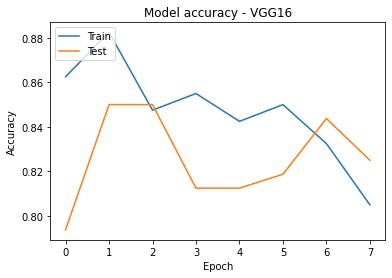

In [132]:
plt.plot(vgghist.history['acc'])
plt.plot(vgghist.history['val_acc'])
plt.title('Model accuracy - VGG16')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [94]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
verbose=1)

28/28 [==============================] - 254s 9s/step


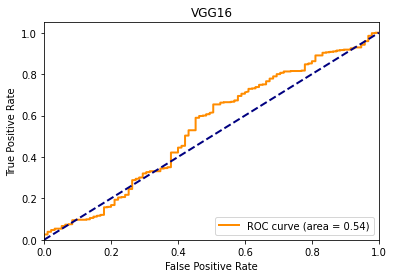

In [95]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16')
plt.legend(loc="lower right")
plt.show()

## Testing Inception

In [96]:
SIZE = 150

In [97]:
# Data Augmentation
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2,
 height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [98]:
# Training and Validation Generators

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAIN_PATH, batch_size = 20, class_mode = 'binary', target_size = (SIZE, SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(TEST_PATH,  batch_size = 20, class_mode = 'binary', target_size = (SIZE, SIZE))

Found 2236 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [99]:
# Loading the Base Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (SIZE, SIZE, 3), include_top = False, weights = 'imagenet')

In [100]:
# Compile and Fit

for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(18432, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [101]:
inc_history = model.fit(train_generator, validation_data = validation_generator, validation_steps= 8,  batch_size=20, steps_per_epoch = 20, epochs = 8)

Epoch 1/8
20/20 [==============================] - 275s 13s/step - loss: 5.0370 - acc: 0.7725 - val_loss: 2.5116 - val_acc: 0.4750
Epoch 2/8
20/20 [==============================] - 241s 12s/step - loss: 2.0114 - acc: 0.7800 - val_loss: 0.8267 - val_acc: 0.8562
Epoch 3/8
20/20 [==============================] - 308s 16s/step - loss: 1.6046 - acc: 0.7900 - val_loss: 2.3467 - val_acc: 0.5375
Epoch 4/8
20/20 [==============================] - 162s 8s/step - loss: 1.4937 - acc: 0.7675 - val_loss: 1.6401 - val_acc: 0.8313
Epoch 5/8
20/20 [==============================] - 126s 6s/step - loss: 1.2371 - acc: 0.8250 - val_loss: 1.9962 - val_acc: 0.4688
Epoch 6/8
20/20 [==============================] - 136s 7s/step - loss: 1.1139 - acc: 0.8000 - val_loss: 0.5711 - val_acc: 0.7500
Epoch 7/8
20/20 [==============================] - 119s 6s/step - loss: 1.2460 - acc: 0.7875 - val_loss: 0.9431 - val_acc: 0.8313
Epoch 8/8
20/20 [==============================] - 115s 6s/step - loss: 0.8391 - acc: 0

In [102]:
# Inceptionv3
model.evaluate(validation_generator)

28/28 [==============================] - 29s 1s/step - loss: 1.4936 - acc: 0.8304


[1.493645191192627, 0.8303571343421936]

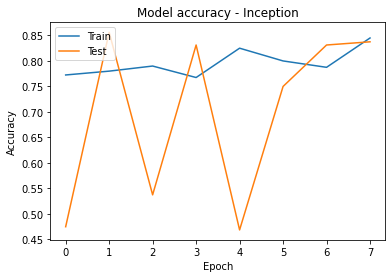

In [133]:
plt.plot(inc_history.history['acc'])
plt.plot(inc_history.history['val_acc'])
plt.title('Model accuracy - Inception')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [103]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
verbose=1)

28/28 [==============================] - 27s 896ms/step


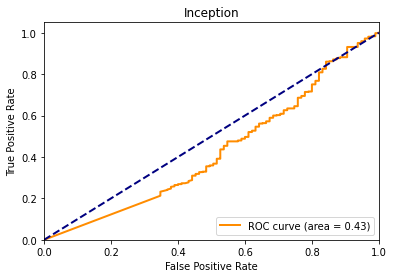

In [104]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Inception')
plt.legend(loc="lower right")
plt.show()

## Testing ResNet50

In [78]:
SIZE=224

In [79]:
# Data Augmentation and Generators
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2,
 height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [80]:

train_generator = train_datagen.flow_from_directory(TRAIN_PATH, batch_size = 20, class_mode = 'binary', target_size = (SIZE, SIZE))

validation_generator = test_datagen.flow_from_directory(TEST_PATH, batch_size = 20, class_mode = 'binary', target_size = (SIZE, SIZE))

Found 2236 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [81]:
#Import the base model
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(SIZE, SIZE,3), include_top=False, weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False

In [82]:
# Build and Compile the Model
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))

#opt = keras.optimizer_v2.gradient_descent.SGD(learning_rate=0.0001)
base_model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['acc'])

In [83]:
resnet_history = base_model.fit(train_generator, batch_size=20, validation_data = validation_generator, validation_steps= 8, 
steps_per_epoch = 20, epochs = 8)

Epoch 1/8
20/20 [==============================] - 295s 15s/step - loss: 5.8954 - acc: 0.7850 - val_loss: 56.9488 - val_acc: 0.8562
Epoch 2/8
20/20 [==============================] - 329s 16s/step - loss: 1.9607 - acc: 0.8150 - val_loss: 61.6931 - val_acc: 0.8062
Epoch 3/8
20/20 [==============================] - 268s 13s/step - loss: 0.4794 - acc: 0.8325 - val_loss: 9.2560 - val_acc: 0.8375
Epoch 4/8
20/20 [==============================] - 293s 15s/step - loss: 0.7408 - acc: 0.8225 - val_loss: 1.2327 - val_acc: 0.8500
Epoch 5/8
20/20 [==============================] - 256s 13s/step - loss: 1.7011 - acc: 0.8500 - val_loss: 5.4125 - val_acc: 0.8062
Epoch 6/8
20/20 [==============================] - 239s 12s/step - loss: 0.4892 - acc: 0.8611 - val_loss: 160.2126 - val_acc: 0.8062
Epoch 7/8
20/20 [==============================] - 251s 13s/step - loss: 2.6202 - acc: 0.8150 - val_loss: 0.4813 - val_acc: 0.8438
Epoch 8/8
20/20 [==============================] - 307s 16s/step - loss: 0.4083

In [84]:
# ResNet50
model.evaluate(validation_generator)

28/28 [==============================] - 14s 504ms/step - loss: 0.8233 - accuracy: 0.8304


[0.8233284950256348, 0.8303571343421936]

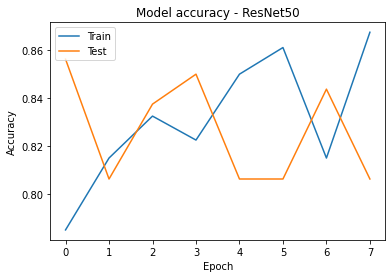

In [134]:
plt.plot(resnet_history.history['acc'])
plt.plot(resnet_history.history['val_acc'])
plt.title('Model accuracy - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [85]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
verbose=1)

28/28 [==============================] - 12s 420ms/step


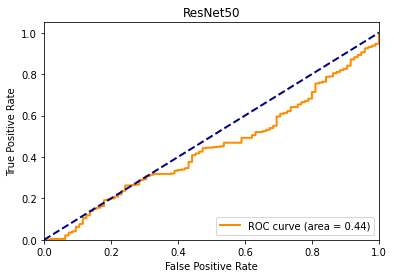

In [86]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50')
plt.legend(loc="lower right")
plt.show()

# CNN com Tensorflow

In [106]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [107]:
SIZE = 224

In [108]:
# Data Augmentation and Generators
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [109]:
train_generator = train_datagen.flow_from_directory(TRAIN_PATH, batch_size = 20, class_mode = 'binary', target_size = (SIZE, SIZE))

validation_generator = test_datagen.flow_from_directory(TEST_PATH, batch_size = 20, class_mode = 'binary', target_size = (SIZE, SIZE))

Found 2236 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [110]:
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(SIZE, SIZE, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
tf.keras.layers.Dense(1, activation='sigmoid')
])

In [111]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
optimizer=RMSprop(learning_rate=0.001),
metrics='accuracy')


In [112]:
cnn_history = model.fit(train_generator, steps_per_epoch=20, epochs=8, verbose=1, validation_data = validation_generator, validation_steps=8)

Epoch 1/8
20/20 [==============================] - 32s 1s/step - loss: 0.5015 - accuracy: 0.8400 - val_loss: 0.4762 - val_accuracy: 0.8062
Epoch 2/8
20/20 [==============================] - 27s 1s/step - loss: 0.3557 - accuracy: 0.8975 - val_loss: 0.4589 - val_accuracy: 0.8188
Epoch 3/8
20/20 [==============================] - 27s 1s/step - loss: 0.4012 - accuracy: 0.8625 - val_loss: 0.4231 - val_accuracy: 0.8438
Epoch 4/8
20/20 [==============================] - 26s 1s/step - loss: 0.4053 - accuracy: 0.8600 - val_loss: 0.6167 - val_accuracy: 0.8313
Epoch 5/8
20/20 [==============================] - 28s 1s/step - loss: 0.4587 - accuracy: 0.8275 - val_loss: 0.5814 - val_accuracy: 0.8188
Epoch 6/8
20/20 [==============================] - 25s 1s/step - loss: 0.4259 - accuracy: 0.8450 - val_loss: 0.5031 - val_accuracy: 0.7937
Epoch 7/8
20/20 [==============================] - 25s 1s/step - loss: 0.3911 - accuracy: 0.8675 - val_loss: 0.3730 - val_accuracy: 0.8562
Epoch 8/8
20/20 [==========

In [113]:
model.evaluate(validation_generator)

28/28 [==============================] - 9s 302ms/step - loss: 0.4076 - accuracy: 0.8304


[0.4075634777545929, 0.8303571343421936]

In [114]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
verbose=1)

28/28 [==============================] - 9s 298ms/step


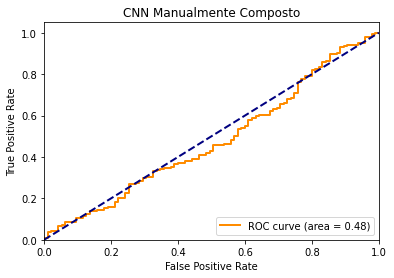

In [115]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Manualmente Composto')
plt.legend(loc="lower right")
plt.show()
